# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Lab 10 - Autoencoders and Variational Autoencoders



**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors**: Mark Glickman and Pavlos Protopapas 


<hr style="height:2pt">

In [1]:
#Install in Jupyter Notebook:
#! pip install imgaug

# Install in terminal:
# pip install opencv-python 

In [5]:
# Unzip data sets
# ! unzip data/fashion_mnist.zip
# ! unzip data/noisy_docs_data.zip

In [6]:
## load the libraries 
import sys
import warnings
import os
import glob
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.metrics import *
from keras.optimizers import Adam, RMSprop
from scipy.stats import norm
from keras.preprocessing import image

from keras import backend as K

from imgaug import augmenters
import matplotlib.pyplot as plt
plt.gray()

<Figure size 432x288 with 0 Axes>

## Part 1: Data

### Reading data

Download the data given at the following link: <insert_link>. Use pandas and numpy to read in the data as a matrix

In [7]:
### read dataset 
train = pd.read_csv("data/fashion-mnist_train.csv")
train_x = train[list(train.columns)[1:]].values
train_x, val_x = train_test_split(train_x, test_size=0.15)

## create train and validation datasets
train_x, val_x = train_test_split(train_x, test_size=0.15)

In [8]:
## normalize and reshape
train_x = train_x/255.
val_x = val_x/255.

train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)

In [9]:
train_x.shape

(43350, 28, 28, 1)

### Visualizing Samples

Visualize 10 images from dataset

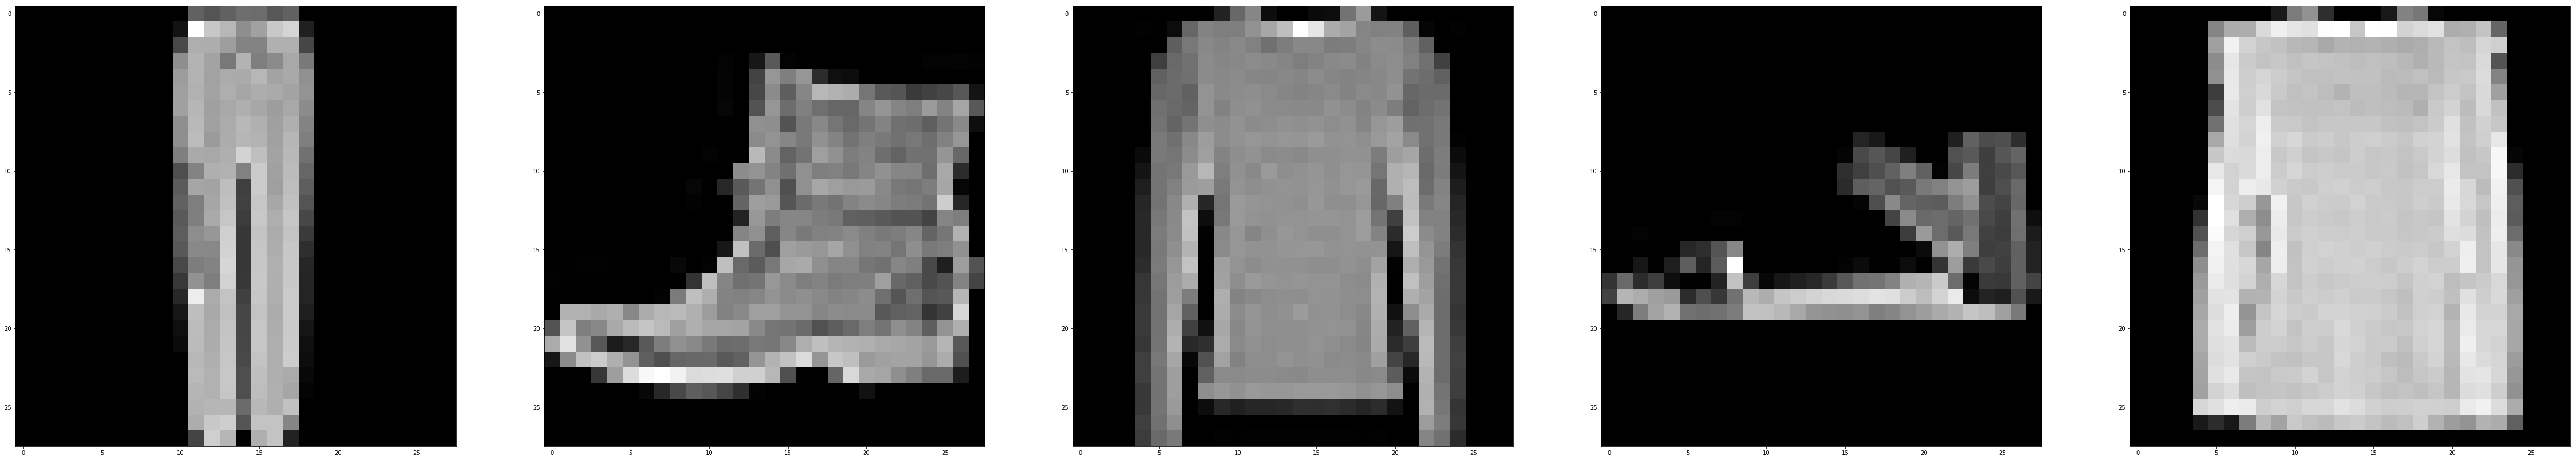

In [10]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(train_x[i, :, :, 0].reshape(28, 28))

## Part 2: Denoise Images using AEs

### Understanding AEs

![Autoencoders](https://cdn-images-1.medium.com/max/1600/1*ZEvDcg1LP7xvrTSHt0B5-Q@2x.png)

### Add Noise to Images

Check out [imgaug docs](https://imgaug.readthedocs.io/en/latest/source/api_augmenters_arithmetic.html) for more info and other ways to add noise.

In [18]:
# Lets add sample noise - Salt and Pepper
noise = augmenters.SaltAndPepper(0.1)
seq_object = augmenters.Sequential([noise])

train_x_n = seq_object.augment_images(train_x * 255) / 255
val_x_n = seq_object.augment_images(val_x * 255) / 255

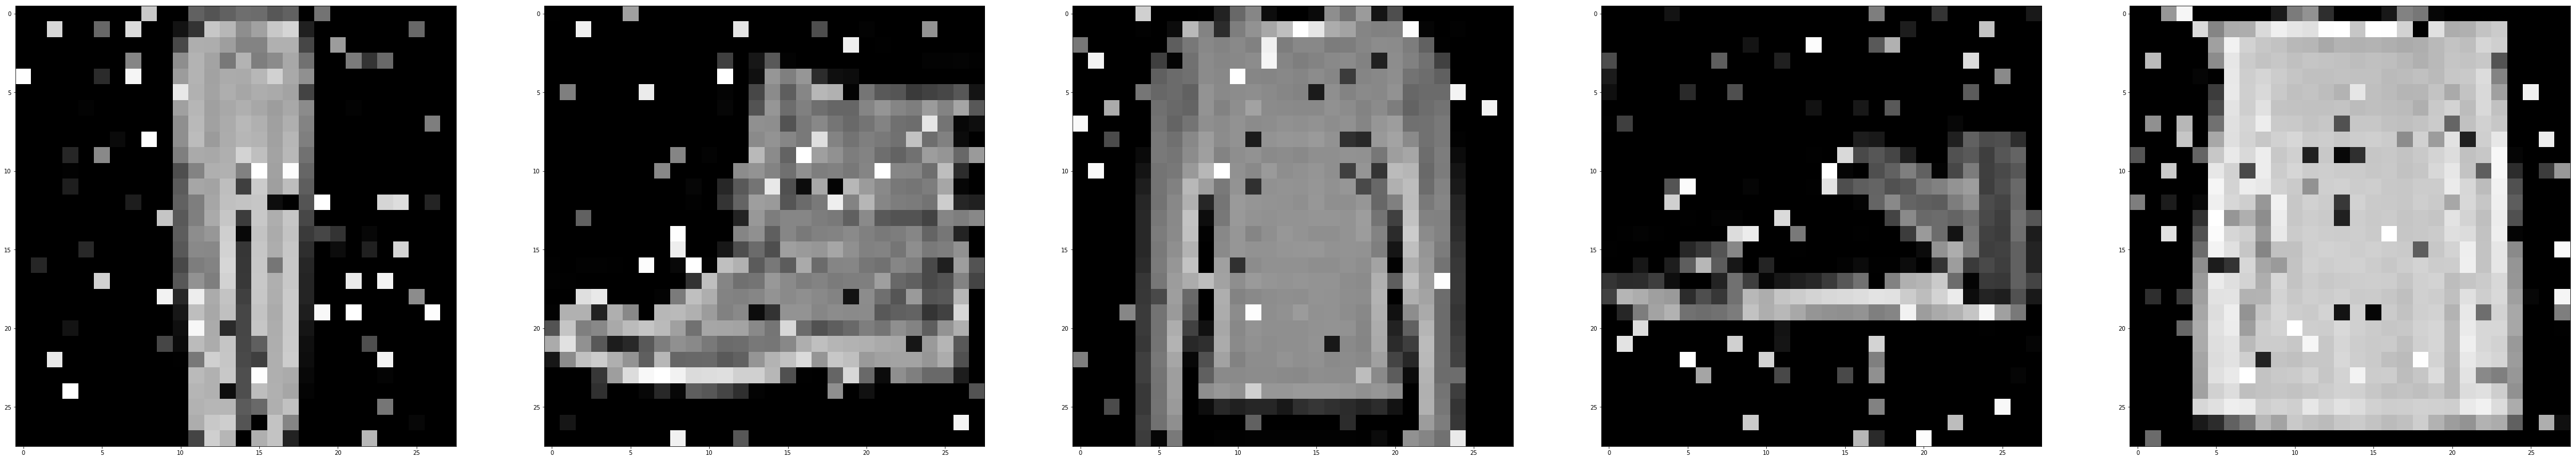

In [19]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(train_x_n[i, :, :, 0].reshape(28, 28))

### Setup Encoder Neural Network

Try different number of hidden layers, nodes?

In [20]:
# input layer
input_layer = Input(shape=(28, 28, 1))

# encoding architecture
encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)
encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPool2D( (2, 2), padding='same')(encoded_layer2)
encoded_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)
latent_view    = MaxPool2D( (2, 2), padding='same')(encoded_layer3)

### Setup Decoder Neural Network

Try different number of hidden layers, nodes?

In [21]:
# decoding architecture
decoded_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)
output_layer   = Conv2D(1, (3, 3), padding='same', activation='sigmoid')(decoded_layer3)

### Train AE

In [22]:
# compile the model
model = Model(input_layer, output_layer)
model.compile(optimizer='adam', loss='mse')

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 16)          4624      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 16)          0         
__________

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')
history = model.fit(train_x_n, train_x, 
                    epochs=20, 
                    batch_size=2048, 
                    validation_data=(val_x_n, val_x), 
                    callbacks=[early_stopping])

Train on 43350 samples, validate on 7650 samples
Epoch 1/20
43350/43350 [==============================] - 179s 4ms/step - loss: 0.1360 - val_loss: 0.0968
Epoch 2/20
43350/43350 [==============================] - 180s 4ms/step - loss: 0.0680 - val_loss: 0.0442
Epoch 3/20
43350/43350 [==============================] - 179s 4ms/step - loss: 0.0394 - val_loss: 0.0352
Epoch 4/20
43350/43350 [==============================] - 180s 4ms/step - loss: 0.0329 - val_loss: 0.0305
Epoch 5/20
43350/43350 [==============================] - 180s 4ms/step - loss: 0.0290 - val_loss: 0.0275
Epoch 6/20
43350/43350 [==============================] - 179s 4ms/step - loss: 0.0266 - val_loss: 0.0259
Epoch 7/20
43350/43350 [==============================] - 179s 4ms/step - loss: 0.0253 - val_loss: 0.0243
Epoch 8/20
43350/43350 [==============================] - 180s 4ms/step - loss: 0.0237 - val_loss: 0.0247
Epoch 9/20
43350/43350 [==============================] - 179s 4ms/step - loss: 0.0241 - val_loss: 0.02

### Visualize Intermediate Layers of AE

Visualize intermediate layers

In [25]:
# compile the model
model_2 = Model(input_layer, latent_view)
model_2.compile(optimizer='adam', loss='mse')

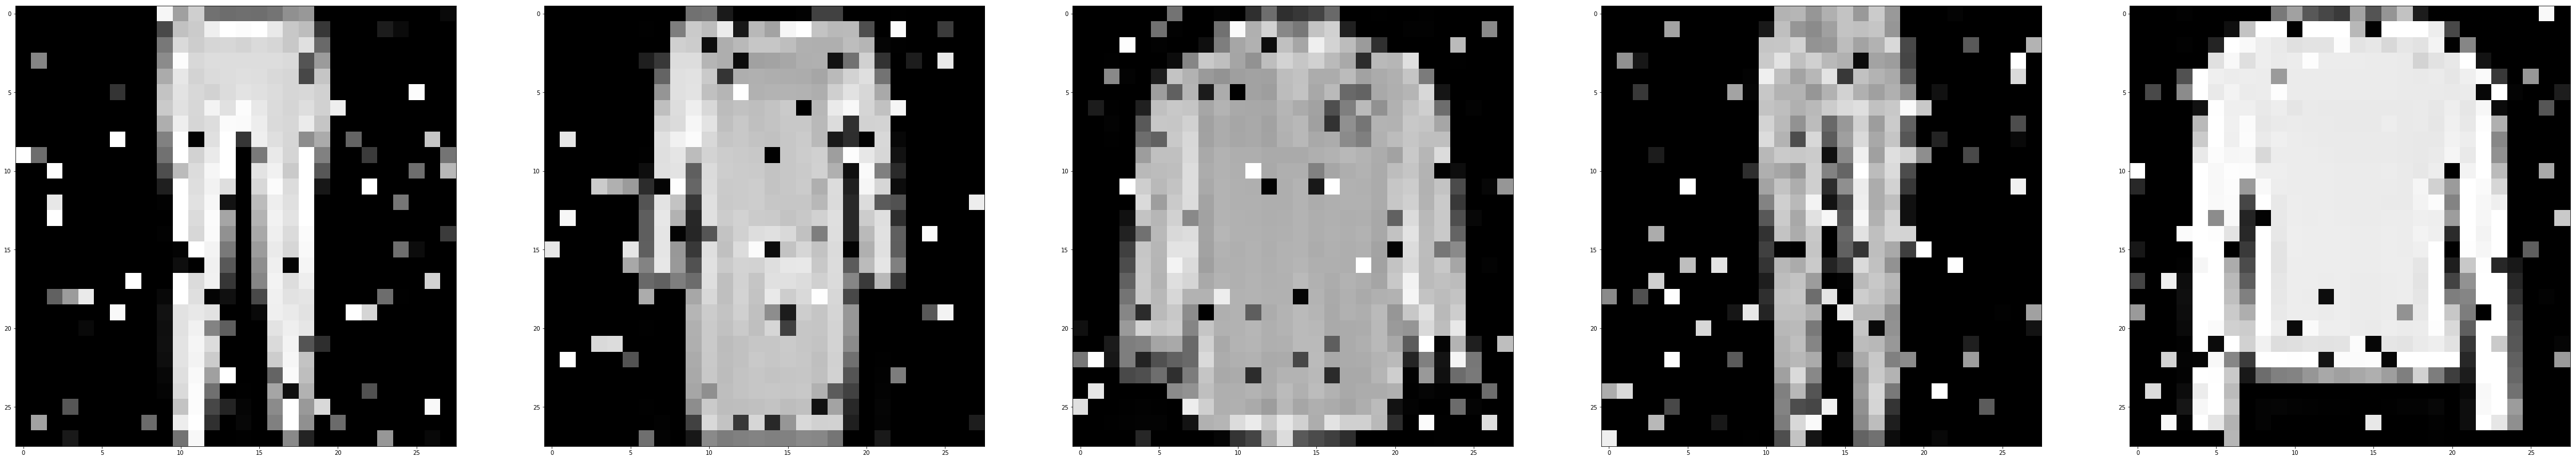

In [26]:
n = np.random.randint(0,len(val_x)-5)
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(val_x_n[a, :, :, 0].reshape(28, 28))
plt.show()

In [27]:
preds = model_2.predict(val_x_n[n:n+5])
preds.shape

(5, 4, 4, 16)

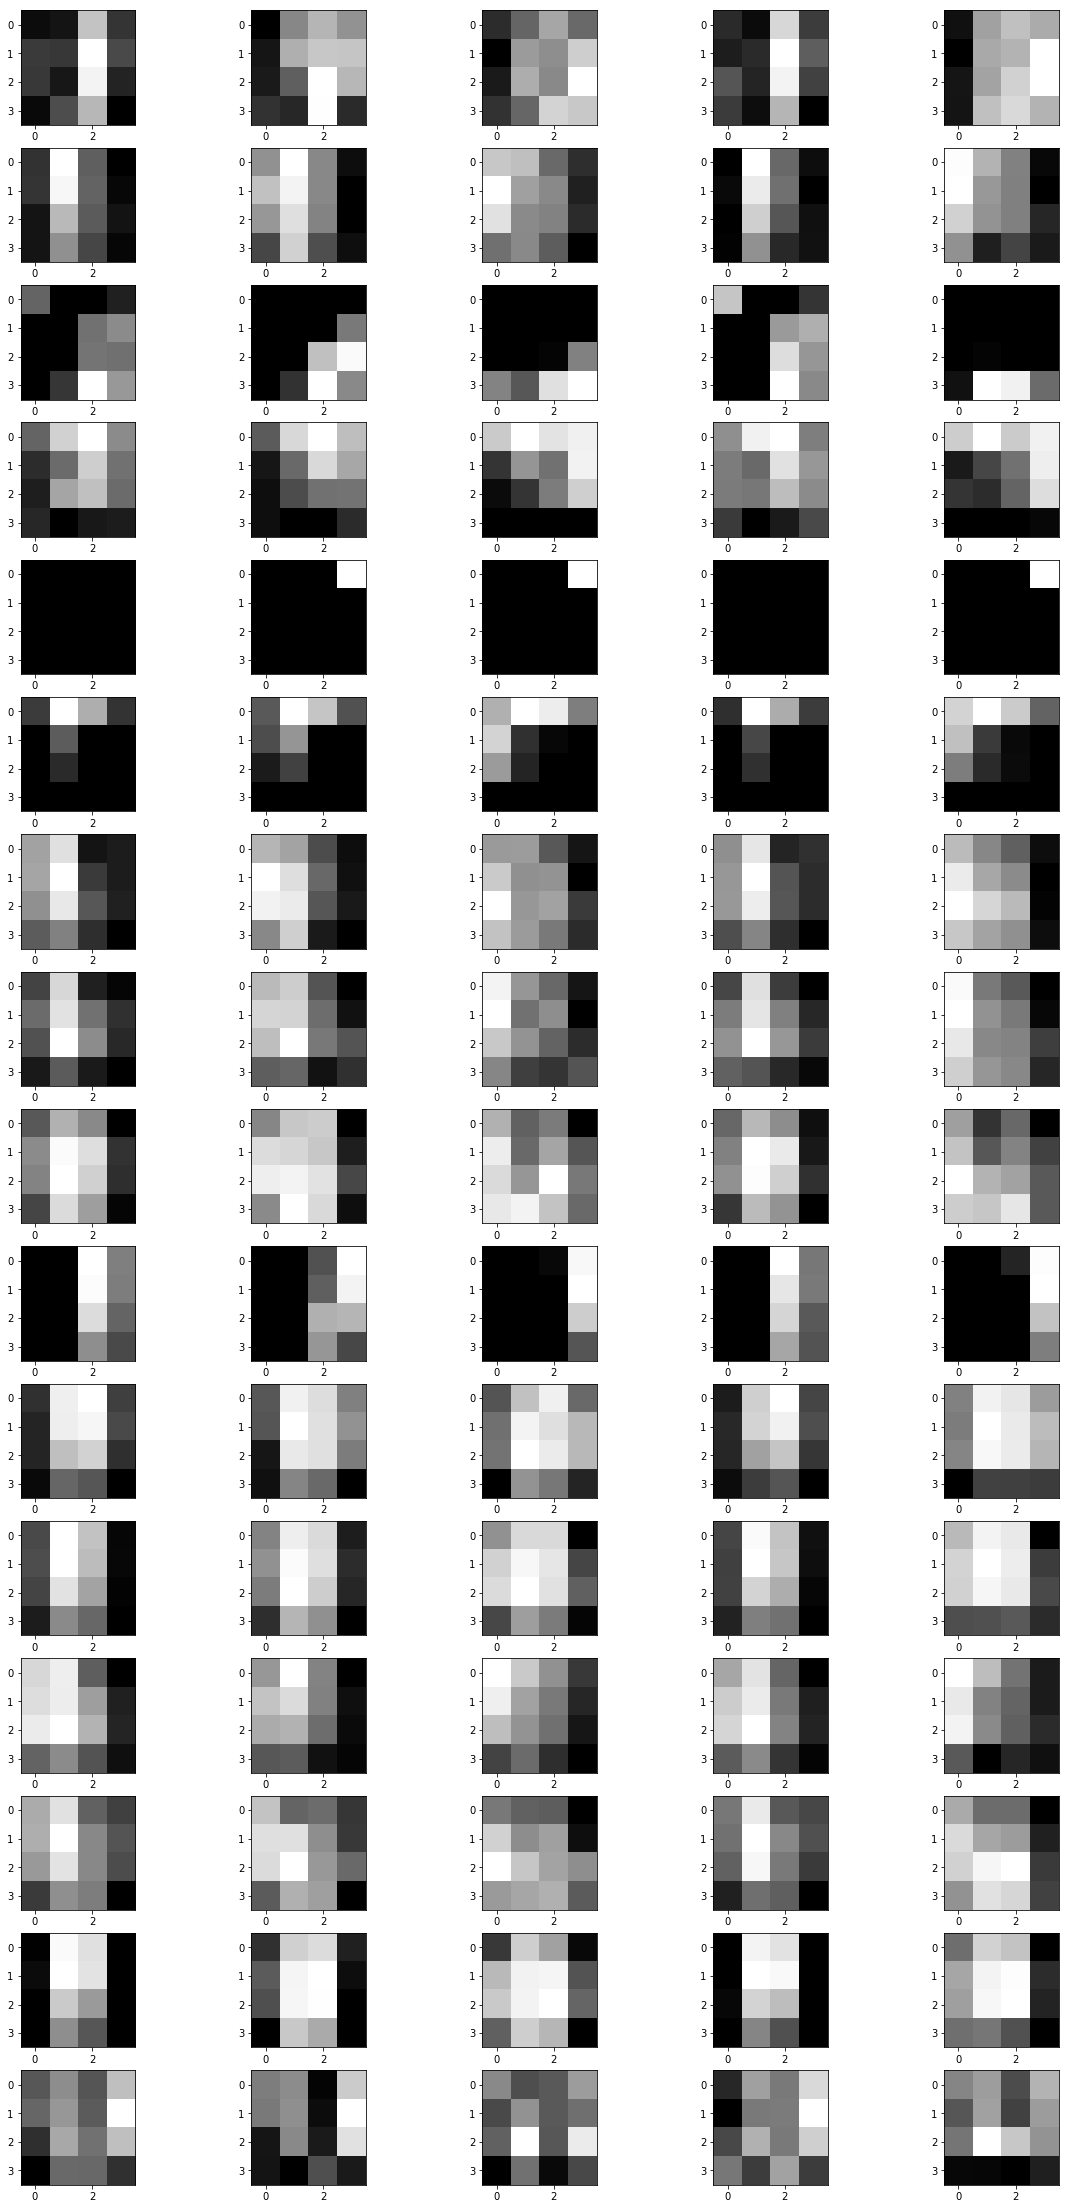

In [28]:
f, ax = plt.subplots(16,5)
ax = ax.ravel()
f.set_size_inches(20, 40)
for j in range(16):
    for i,a in enumerate(range(n,n+5)):
        ax[j*5 + i].imshow(preds[i, :, :, j])
plt.show()

### Visualize Samples reconstructed by AE

In [29]:
n = np.random.randint(0,len(val_x)-5)

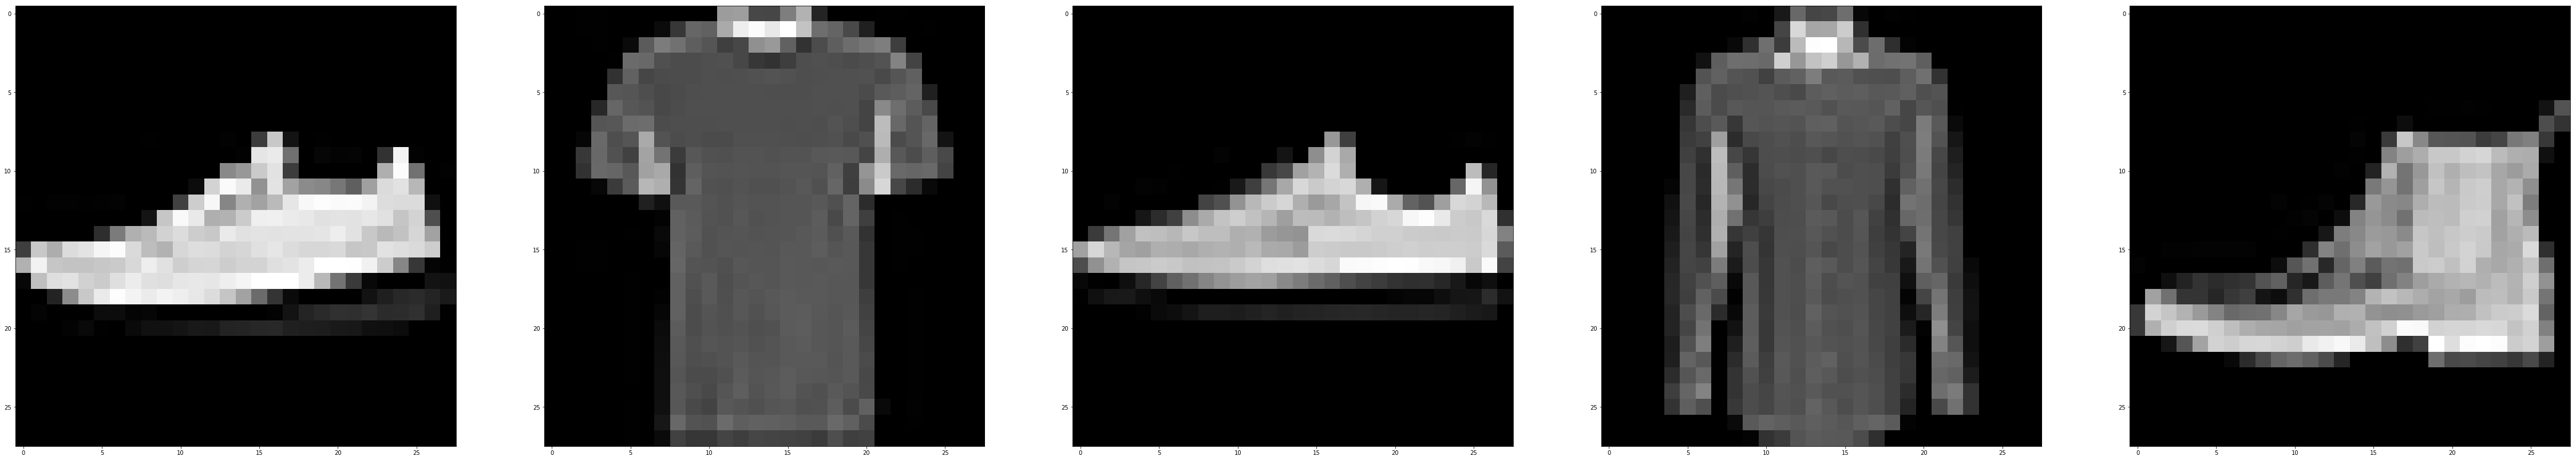

In [30]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(val_x[a, :, :, 0].reshape(28, 28))

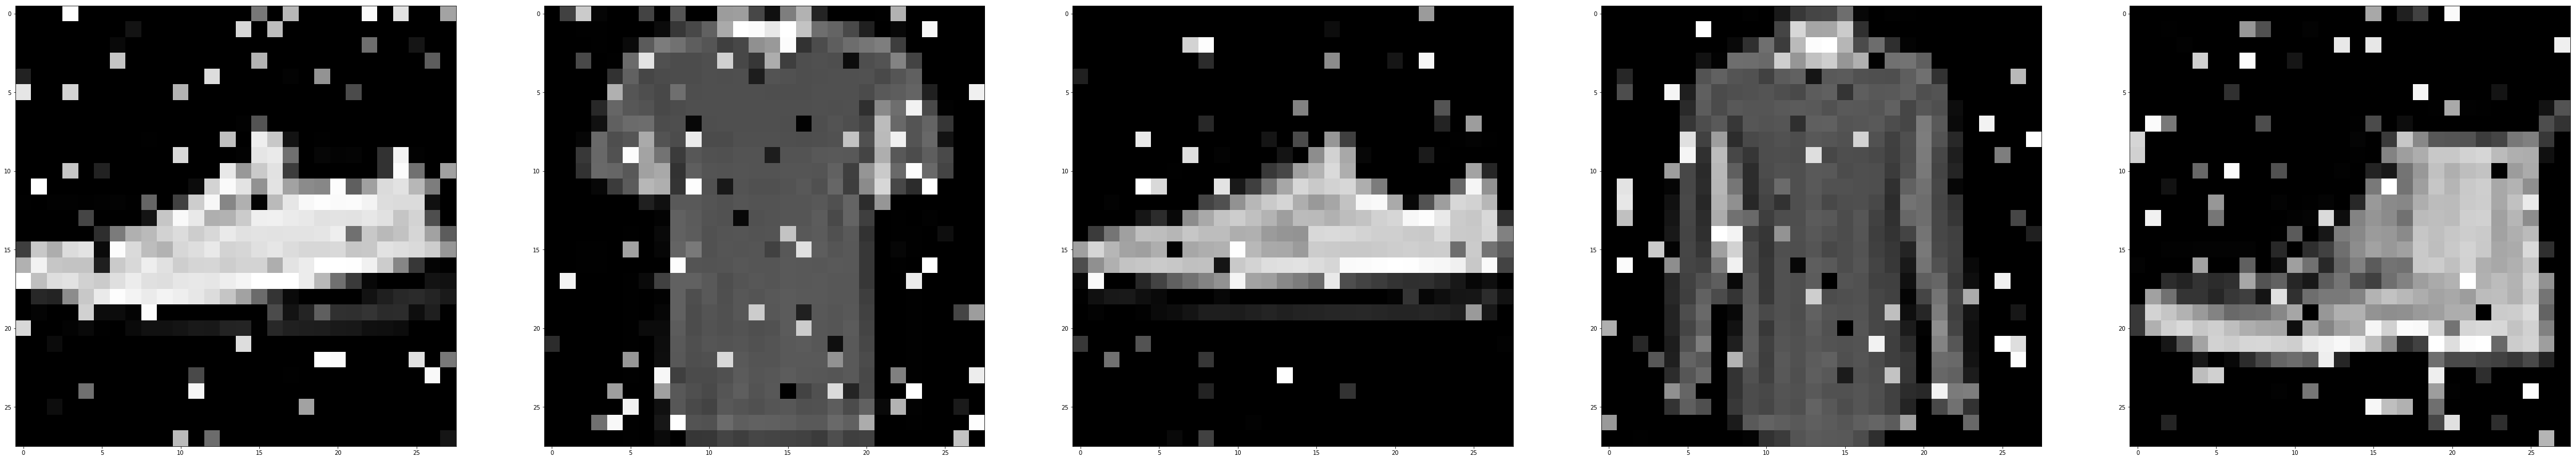

In [31]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(val_x_n[a, :, :, 0].reshape(28, 28))

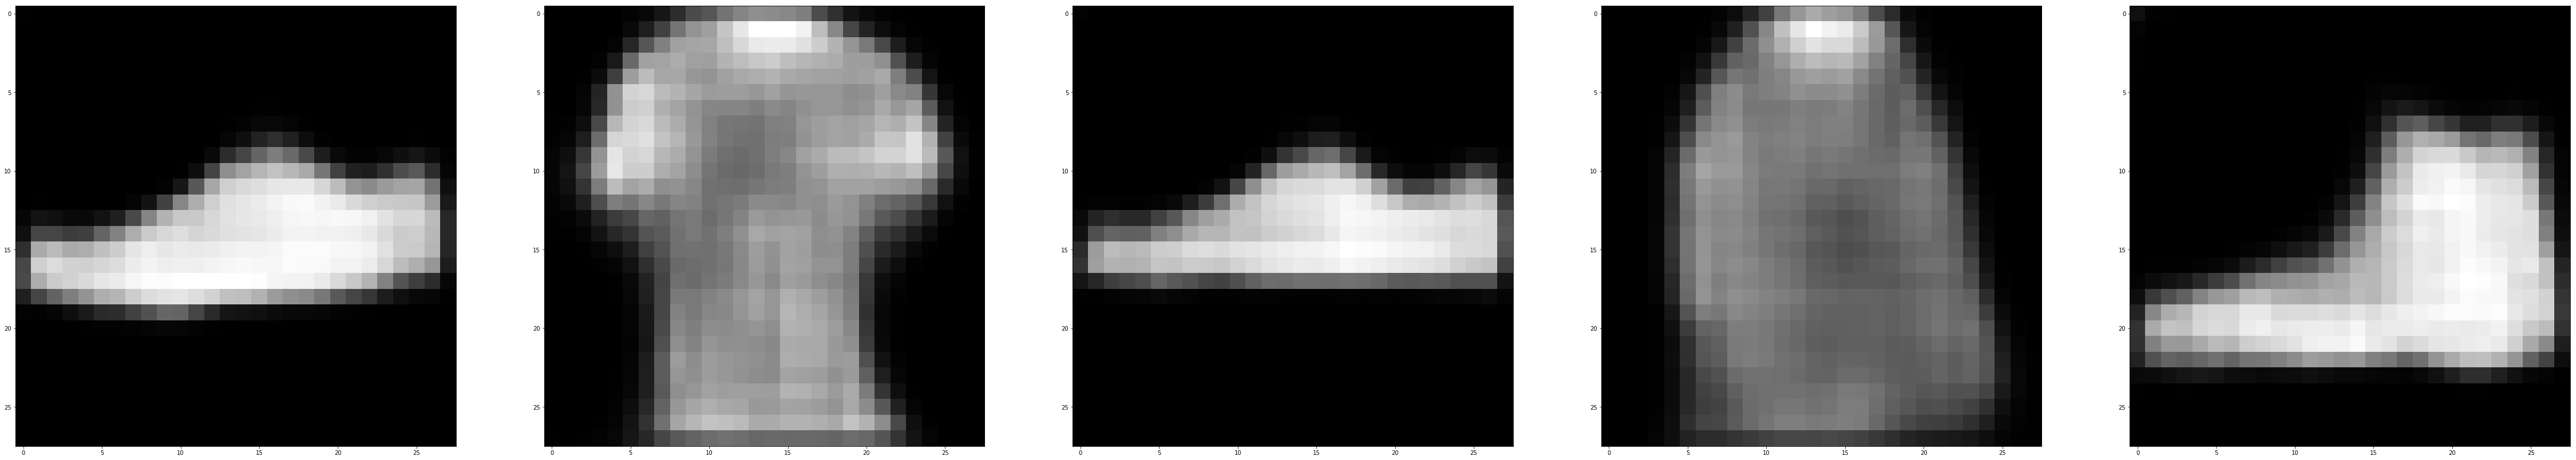

In [32]:
preds = model.predict(val_x_n[n:n+5])
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(preds[i].reshape(28, 28))
plt.show()

## Part 3: Exercise: Denoising noisy documents

In [33]:
TRAIN_IMAGES = glob.glob('data/train/*.png')
CLEAN_IMAGES = glob.glob('data/train_cleaned/*.png')
TEST_IMAGES = glob.glob('data/test/*.png')

(420, 540)


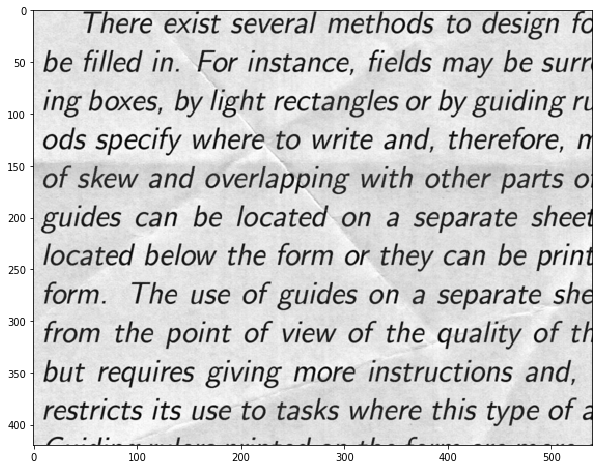

In [34]:
plt.figure(figsize=(20,8))
img = cv2.imread('data/train/101.png', 0)
plt.imshow(img, cmap='gray')
print(img.shape)

In [35]:
def load_image(path):
    image_list = np.zeros((len(path), 258, 540, 1))
    for i, fig in enumerate(path):
        img = image.load_img(fig, grayscale=True, target_size=(258, 540))
        x = image.img_to_array(img).astype('float32')
        x = x / 255.0
        image_list[i] = x
    
    return image_list

x_train = load_image(TRAIN_IMAGES)
y_train = load_image(CLEAN_IMAGES)
x_test = load_image(TEST_IMAGES)

print(x_train.shape, x_test.shape)

(144, 258, 540, 1) (72, 258, 540, 1)


In [36]:
x_train.shape

(144, 258, 540, 1)

In [37]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15)
print(x_train.shape, x_val.shape)

(122, 258, 540, 1) (22, 258, 540, 1)


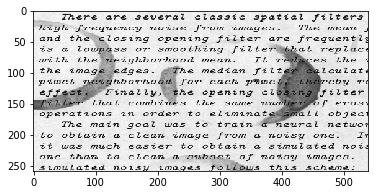

In [38]:
plt.imshow(x_train[0, :, :, 0])

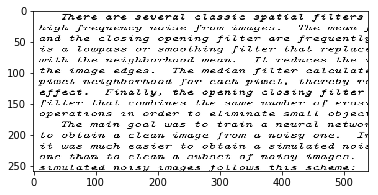

In [39]:
plt.imshow(y_train[0, :, :, 0])

In [40]:
input_layer = Input(shape=(258, 540, 1))
        
# encoder
encoder = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoder = MaxPooling2D((2, 2), padding='same')(encoder)

# decoder
decoder = Conv2D(64, (3, 3), activation='relu', padding='same')(encoder)
decoder = UpSampling2D((2, 2))(decoder)
output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoder)

ae = Model(input_layer, output_layer)

In [41]:
ae.compile(loss='mse', optimizer=Adam(lr=0.001))
ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 258, 540, 1)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 258, 540, 64)      640       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 129, 270, 64)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 129, 270, 64)      36928     
_________________________________________________________________
up_sampling2d_7 (UpSampling2 (None, 258, 540, 64)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 258, 540, 1)       577       
Total params: 38,145
Trainable params: 38,145
Non-trainable params: 0
_________________________________________________________________


In [42]:
batch_size = 16
epochs = 200

early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=5,verbose=1, mode='auto')
history = ae.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), callbacks=[early_stopping])

Train on 122 samples, validate on 22 samples
Epoch 1/200
 32/122 [======>.......................] - ETA: 1:02 - loss: 0.1775

KeyboardInterrupt: 

In [ ]:
preds = ae.predict(x_test)

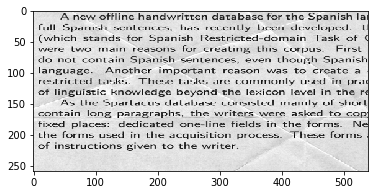

In [33]:
n = 25
preds_0 = preds[n] * 255.0
preds_0 = preds_0.reshape(258, 540)
x_test_0 = x_test[n] * 255.0
x_test_0 = x_test_0.reshape(258, 540)
plt.imshow(x_test_0, cmap='gray')

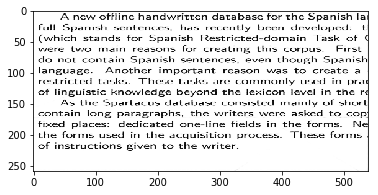

In [34]:
plt.imshow(preds_0, cmap='gray')

## Part 4: Generating New Fashion using VAEs

### Understanding VAEs

!["VAE"](http://www.cvc.uab.es/people/joans/slides_tensorflow/tensorflow_html/vae_files/ae.png)

### Reset data

In [52]:
### read dataset 
train = pd.read_csv("data/fashion-mnist_train.csv")
train_x = train[list(train.columns)[1:]].values
train_x, val_x = train_test_split(train_x, test_size=0.2)

## create train and validation datasets
train_x, val_x = train_test_split(train_x, test_size=0.2)

In [53]:
## normalize and reshape
train_x = train_x/255.
val_x = val_x/255.

train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)

### Setup Encoder Neural Network

Try different number of hidden layers, nodes?

In [54]:
import keras.backend as K

In [57]:
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters

input_img = Input(shape=(784,), name="input")
x = Dense(512, activation='relu', name="intermediate_encoder")(input_img)
x = Dense(2, activation='relu', name="latent_encoder")(x)

z_mu = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim)(x)

**Note:** that the `latent_dim` here is not the actual number of variables in the latent space. Its the number of parameters that define the distribution of the latent variables. So for each latent variable there will be two variables, and thus, in total there will be `latent_dim` number of $\mu$'s and `latent_dim` number of $\sigma$'s. Here its the variables `z_mu` and `z_log_sigma`.

In [58]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = Lambda(sampling)([z_mu, z_log_sigma])

In [59]:
# decoder takes the latent distribution sample as input
decoder_input = Input((2,), name="input_decoder")

x = Dense(512, activation='relu', name="intermediate_decoder", input_shape=(2,))(decoder_input)

# Expand to 784 total pixels
x = Dense(784, activation='sigmoid', name="original_decoder")(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

In [60]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_decoder (InputLayer)   (None, 2)                 0         
_________________________________________________________________
intermediate_decoder (Dense) (None, 512)               1536      
_________________________________________________________________
original_decoder (Dense)     (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


In [61]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = binary_crossentropy(x, z_decoded)
        return xent_loss

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

In [62]:
z_decoded

<tf.Tensor 'model_6/original_decoder/Sigmoid:0' shape=(?, 784) dtype=float32>

In [63]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)

In [64]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 784)          0                                            
__________________________________________________________________________________________________
intermediate_encoder (Dense)    (None, 512)          401920      input[0][0]                      
__________________________________________________________________________________________________
latent_encoder (Dense)          (None, 2)            1026        intermediate_encoder[0][0]       
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 2)            6           latent_encoder[0][0]             
__________________________________________________________________________________________________
dense_6 (D

In [65]:
train_x.shape

(38400, 28, 28, 1)

In [66]:
train_x = train_x.reshape(-1, 784)
val_x = val_x.reshape(-1, 784)

In [67]:
vae.fit(x=train_x, y=None,
        shuffle=True,
        epochs=20,
        batch_size=batch_size,
        validation_data=(val_x, None))

Train on 38400 samples, validate on 9600 samples
Epoch 1/20
38400/38400 [==============================] - 22s 563us/step - loss: 0.4930 - val_loss: 0.4914
Epoch 2/20
38400/38400 [==============================] - 21s 557us/step - loss: 0.4907 - val_loss: 0.4913
Epoch 3/20
38400/38400 [==============================] - 21s 548us/step - loss: 0.4905 - val_loss: 0.4922
Epoch 4/20
38400/38400 [==============================] - 21s 550us/step - loss: 0.4904 - val_loss: 0.4913
Epoch 5/20
38400/38400 [==============================] - 21s 548us/step - loss: 0.4904 - val_loss: 0.4913
Epoch 6/20
38400/38400 [==============================] - 21s 542us/step - loss: 0.4904 - val_loss: 0.4913
Epoch 7/20
38400/38400 [==============================] - 21s 546us/step - loss: 0.4904 - val_loss: 0.4913
Epoch 8/20
38400/38400 [==============================] - 21s 542us/step - loss: 0.4904 - val_loss: 0.4915
Epoch 9/20
38400/38400 [==============================] - 21s 549us/step - loss: 0.4904 - val_l

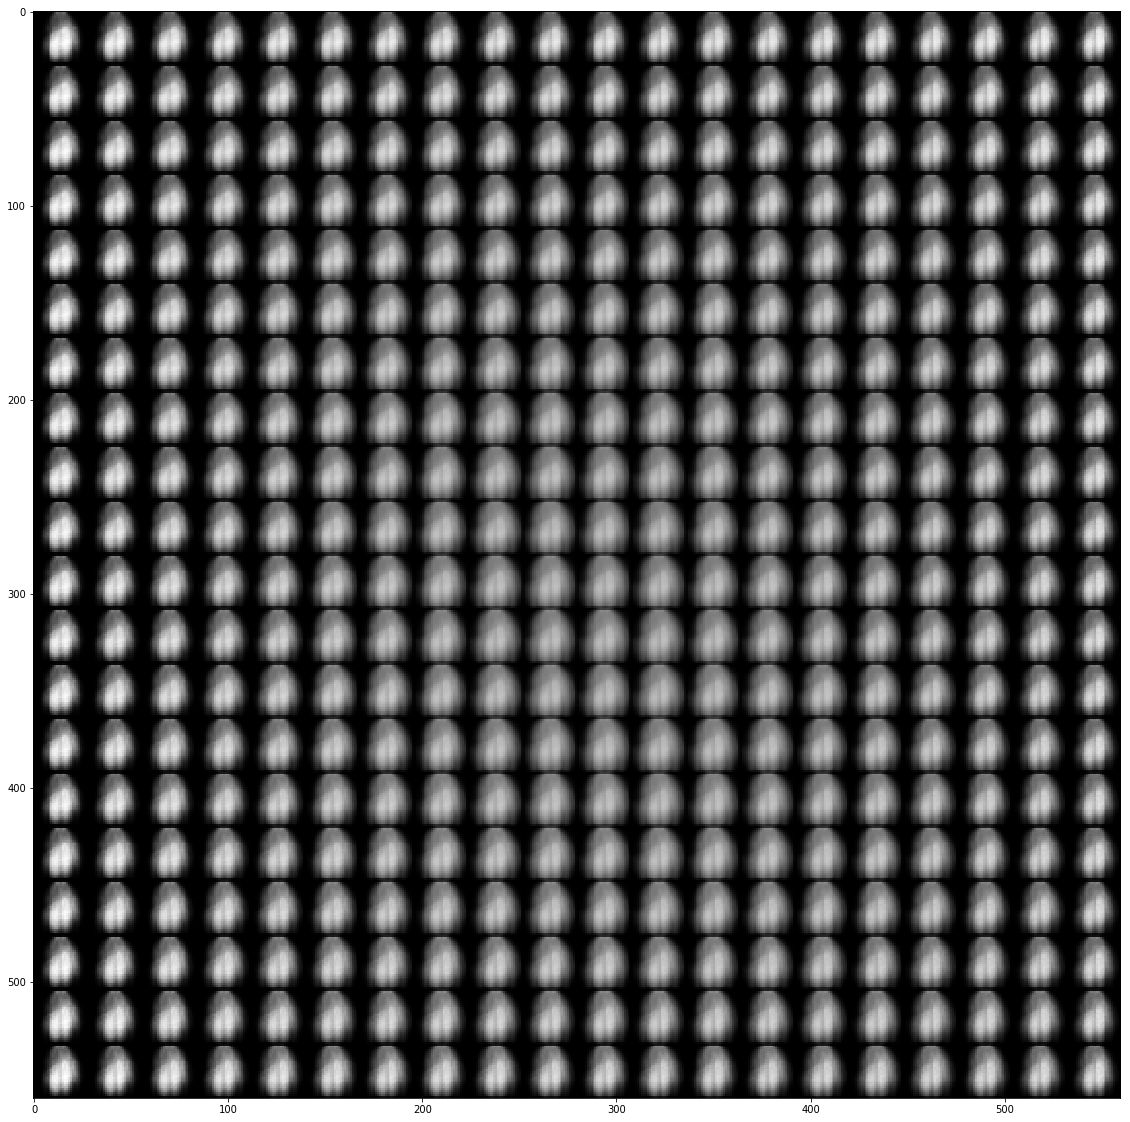

In [68]:
# Display a 2D manifold of the samples
n = 20  # figure with 20x20 samples
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values - can change values here to generate different things
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        
        digit = x_decoded[0].reshape(digit_size, digit_size)
        
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
plt.imshow(figure)
plt.show()  

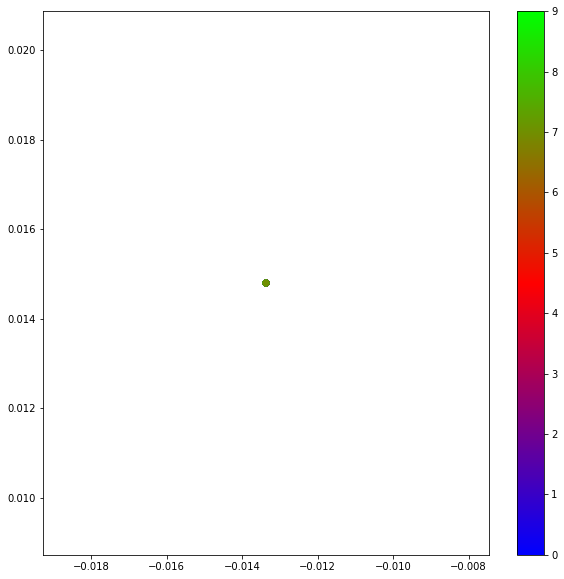

In [70]:
### read dataset 
train = pd.read_csv("data/fashion-mnist_train.csv")
train_x = train[list(train.columns)[1:]].values
train_y = train[list(train.columns)[0]].values

train_x = train_x/255.
# train_x = train_x.reshape(-1, 28, 28, 1)

# Translate into the latent space
encoder = Model(input_img, z_mu)
x_valid_noTest_encoded = encoder.predict(train_x, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_noTest_encoded[:, 0], x_valid_noTest_encoded[:, 1], c=train_y, cmap='brg')
plt.colorbar()
plt.show()

## Part 5: Exercise: Generating New Fashion using VAEs: Adding CNNs and KL Divergence Loss

In [71]:
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters

# Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
input_img = Input(shape=(28, 28, 1))

x = Conv2D(32, 3,
                  padding='same', 
                  activation='relu')(input_img)
x = Conv2D(64, 3,
                  padding='same', 
                  activation='relu',
                  strides=(2, 2))(x)
x = Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)
x = Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)

# need to know the shape of the network here for the decoder
shape_before_flattening = K.int_shape(x)

x = Flatten()(x)
x = Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim)(x)

### Set up sampling function

In [72]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = Lambda(sampling)([z_mu, z_log_sigma])

### Setup Decoder Neural Network

Try different number of hidden layers, nodes?

In [73]:
# decoder takes the latent distribution sample as input
decoder_input = Input(K.int_shape(z)[1:])

# Expand to 784 total pixels
x = Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# reshape
x = Reshape(shape_before_flattening[1:])(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
x = Conv2DTranspose(32, 3,
                           padding='same', 
                           activation='relu',
                           strides=(2, 2))(x)
x = Conv2D(1, 3,
                  padding='same', 
                  activation='sigmoid')(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

### Set up loss functions

In [74]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

### Train VAE

In [75]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)

In [76]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 28, 28, 32)   320         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 14, 14, 64)   18496       conv2d_18[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 14, 14, 64)   36928       conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_21 

In [78]:
train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)

In [80]:
vae.fit(x=train_x, y=None,
        shuffle=True,
        epochs=5,
        batch_size=5000,
        validation_data=(val_x, None))

Train on 60000 samples, validate on 9600 samples
Epoch 1/5
10000/60000 [====>.........................] - ETA: 5:28 - loss: 0.3867

KeyboardInterrupt: 

### Visualize Samples reconstructed by VAE

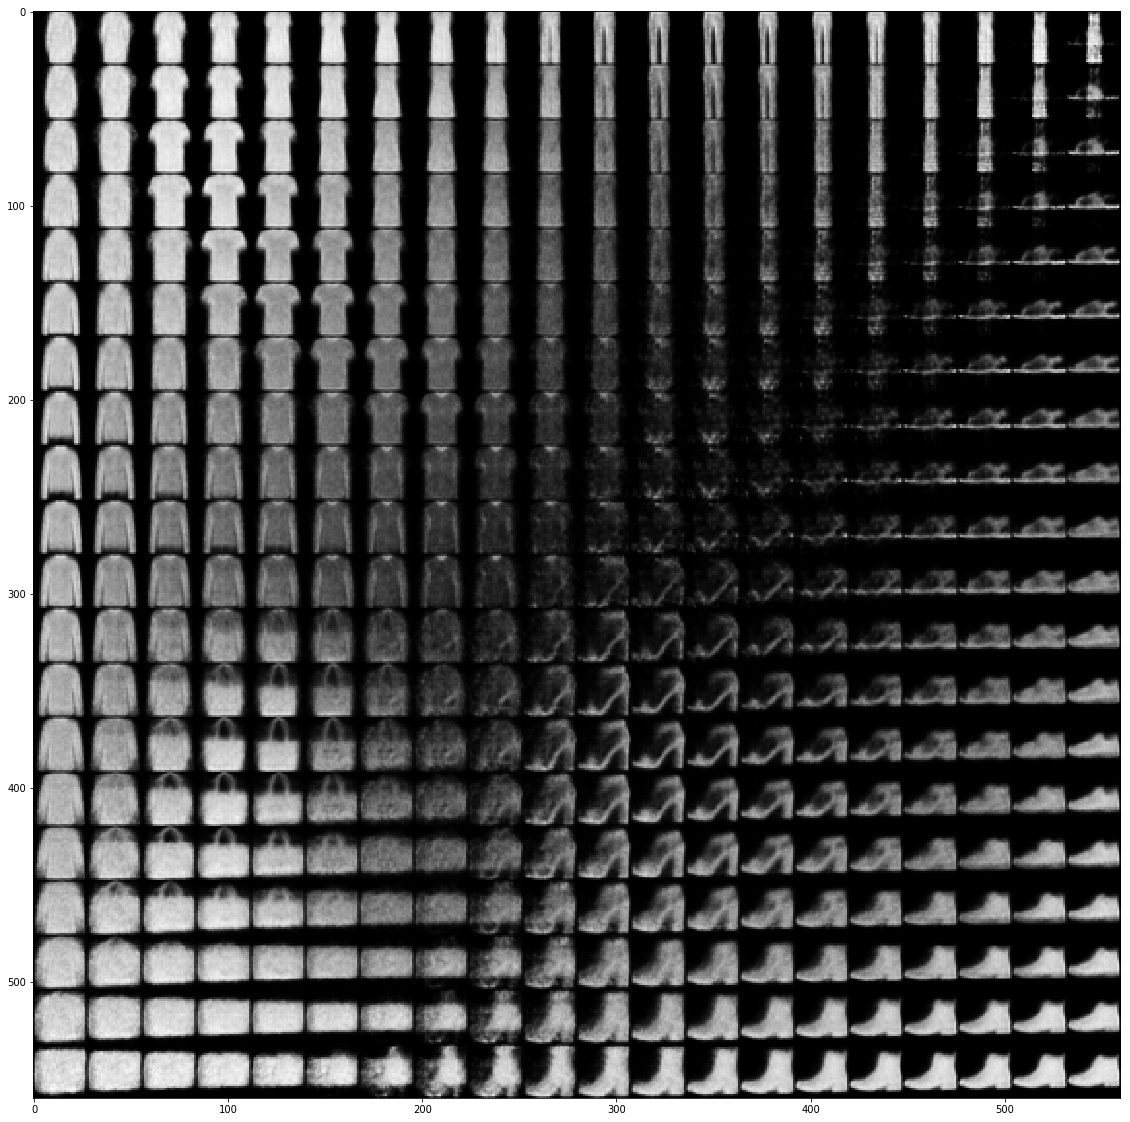

In [59]:
# Display a 2D manifold of the samples
n = 20  # figure with 20x20 samples
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values - can change values here to generate different things
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
plt.imshow(figure)
plt.show()  

## TODO:
#### VAE: Visualize latent space

In [60]:
train = pd.read_csv("data/fashion-mnist_train.csv")


In [61]:
### read dataset 
train = pd.read_csv("data/fashion-mnist_train.csv")
train_x = train[list(train.columns)[1:]].values
train_y = train[list(train.columns)[0]].values

train_x = train_x/255.
train_x = train_x.reshape(-1, 28, 28, 1)

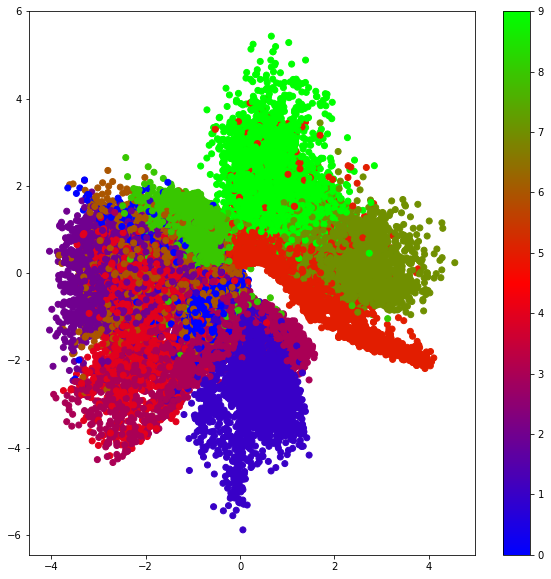

In [62]:
# Translate into the latent space
encoder = Model(input_img, z_mu)
x_valid_noTest_encoded = encoder.predict(train_x, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_noTest_encoded[:, 0], x_valid_noTest_encoded[:, 1], c=train_y, cmap='brg')
plt.colorbar()
plt.show()